In [1]:
import pandas as pd
pd.set_option('display.max_colwidth', 500)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import _pickle as pickle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import calinski_harabasz_score, silhouette_score, davies_bouldin_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tqdm.notebook import tqdm
import os

In [2]:
path = os.getcwd() + "/Pickles/refined_profiles.pkl"
print(path)
with open(path,'rb') as fp:
    df = pickle.load(fp)

# Viewing the DF    
df

/Users/dianaomomehin/Desktop/ML-Matchmaking/Pickles/refined_profiles.pkl


,Profiles,Style,Age,Rate
0,"Masculine, Casual, Preppy, Glam","[Dramatic, Editorial, Edgy, Masculine]",27,30
1,"Masculine, Glam, Vintage, Preppy","[Minimalist, Romantic, Androgynous]",27,82
2,"Sexy, Feminine, Edgy, Editorial","[Classic, Elegant, Editorial]",25,27
3,"Classic, Editorial, Androgynous, Feminine","[Classic, Romantic, Editorial, Vintage]",24,73
4,"Maximalist, Androgynous, Elegant, Masculine","[Glam, Classic, Androgynous]",21,47
...,...,...,...,...
73438,"Maximalist, Minimalist, Classic, Feminine","[Classic, Edgy, Androgynous]",38,91
73439,"Glam, Androgynous, Maximalist, Editorial","[Vintage, Editorial, Feminine]",24,54
73440,"Feminine, Classic",Feminine Classic,0,25
73441,"funky, mature, nice",funky mature nice,24,25


## Clustering the Data

In [3]:
def string_convert(x):
    """
    First converts the lists in the DF into strings
    """
    if isinstance(x, list):
        return ' '.join(x)
    else:
        return x
    
# Looping through the columns and applying the function
for col in df.columns:
    df[col] = df[col].apply(string_convert)

In [4]:
df = df[['Profiles', 'Style','Age', 'Rate']]
df

,Profiles,Style,Age,Rate
0,"Masculine, Casual, Preppy, Glam",Dramatic Editorial Edgy Masculine,27,30
1,"Masculine, Glam, Vintage, Preppy",Minimalist Romantic Androgynous,27,82
2,"Sexy, Feminine, Edgy, Editorial",Classic Elegant Editorial,25,27
3,"Classic, Editorial, Androgynous, Feminine",Classic Romantic Editorial Vintage,24,73
4,"Maximalist, Androgynous, Elegant, Masculine",Glam Classic Androgynous,21,47
...,...,...,...,...
73438,"Maximalist, Minimalist, Classic, Feminine",Classic Edgy Androgynous,38,91
73439,"Glam, Androgynous, Maximalist, Editorial",Vintage Editorial Feminine,24,54
73440,"Feminine, Classic",Feminine Classic,0,25
73441,"funky, mature, nice",funky mature nice,24,25


In [5]:
def vectorization(df, columns):
    """
    Using recursion, iterate through the df until all the categories have been vectorized
    """
    column_name = columns[0]
    
    # Checking if the column name has been removed already
    if column_name not in ['Profiles', 'Style']:
        return df
    
    else:
        # Instantiating the Vectorizer
        vectorizer = CountVectorizer()
        
        # Fitting the vectorizer to the Bios
        x = vectorizer.fit_transform(df[column_name])

        # Creating a new DF that contains the vectorized words
        df_wrds = pd.DataFrame(x.toarray(), columns=vectorizer.get_feature_names_out())

        # Concating the words DF with the original DF
        df = df.loc[~df.index.duplicated(keep='first')]
        df_wrds = df_wrds.loc[~df_wrds.index.duplicated(keep='first')]
        new_df = pd.concat([df, df_wrds], axis=1)

        # Dropping the column because it is no longer needed in place of vectorization
        new_df = new_df.drop(column_name, axis=1)
        new_df = new_df.dropna()
        new_df = new_df.reset_index(drop=True)
        
        return vectorization(new_df, new_df.columns) 

In [6]:
# Creating the vectorized DF
vect_df = vectorization(df, df.columns)
vect_df

,Age,Rate,18,25,49,androgynous,boho,casual,classic,dramatic,...,mature,maximalist,minimalist,nice,preppy,romantic,sexy,streetwear,than,vintage
0,27,30,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,27,82,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
2,25,27,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,24,73,0,0,0,1,0,0,1,0,...,0,0,0,0,0,1,0,0,0,1
4,21,47,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73438,38,91,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
73439,24,54,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
73440,0,25,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
73441,24,25,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0


In [7]:
scaler = MinMaxScaler()

vect_df = pd.DataFrame(scaler.fit_transform(vect_df), index=vect_df.index, columns=vect_df.columns)

In [8]:
vect_df

,Age,Rate,18,25,49,androgynous,boho,casual,classic,dramatic,...,mature,maximalist,minimalist,nice,preppy,romantic,sexy,streetwear,than,vintage
0,0.500000,0.073171,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.500000,0.284553,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.462963,0.060976,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.444444,0.247967,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0.388889,0.142276,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73438,0.703704,0.321138,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
73439,0.444444,0.170732,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
73440,0.000000,0.052846,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
73441,0.444444,0.052846,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


## PCA

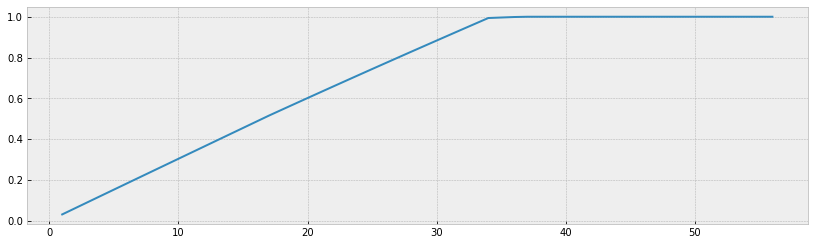

PCA reduces the # of features from 56 to 33


0.9662688948115962

In [9]:
from sklearn.decomposition import PCA

# Performing dimension reduction
# Instantiating PCA
pca = PCA()

# Fitting and Transforming the DF
df_pca = pca.fit_transform(vect_df)

# Plotting to determine how many features should the dataset be reduced to
plt.style.use("bmh")
plt.figure(figsize=(14,4))
plt.plot(range(1,vect_df.shape[1]+1), pca.explained_variance_ratio_.cumsum())
plt.show()

# Finding the exact number of features to maximize the variance in the data
total_explained_variance = pca.explained_variance_ratio_.cumsum()
n_over_95 = len(total_explained_variance[total_explained_variance>=.99])
n_to_reach_95 = vect_df.shape[1] - n_over_95

print("PCA reduces the # of features from", vect_df.shape[1], 'to', n_to_reach_95)

# Reducing the dataset to the number of features determined before
pca = PCA(n_components=n_to_reach_95)

# Fitting and transforming the dataset to the stated number of features
df_pca = pca.fit_transform(vect_df)

# Seeing the variance ratio that still remains after the dataset has been reduced
pca.explained_variance_ratio_.cumsum()[-1]

In [10]:
# Instantiating KMeans
k_means = KMeans(n_clusters=4)

# Fitting
k_means.fit(df_pca)

# Getting cluster assignments
cluster_assignments = k_means.predict(df_pca)

# Setting an evaluation score or metric
print(calinski_harabasz_score(df_pca, cluster_assignments))

1967.1776046740024


In [11]:
# Setting the amount of clusters to test out
# cluster_cnt = [i for i in range(2, , 2)]

# Establishing empty lists to store the scores for the evaluation metrics
ch_scores = []

s_scores = []

db_scores = []
cluster_cnt = [i for i in range(2, 40, 2)]

# Looping through different iterations for the number of clusters
for i in tqdm(cluster_cnt):
    
    # Clustering with different number of clusters
    k_means = KMeans(n_clusters=i)
    
    k_means.fit(df_pca)
    
    cluster_assignments = k_means.predict(df_pca)
    
    # Appending the scores to the empty lists
    ch_scores.append(calinski_harabasz_score(df_pca, cluster_assignments))
    
    s_scores.append(silhouette_score(df_pca, cluster_assignments))
    
    db_scores.append(davies_bouldin_score(df_pca, cluster_assignments))

  0%|          | 0/19 [00:00<?, ?it/s]

### Using KMeans loss to get optimum number of clusters


In [12]:
def cluster_eval(y, x):
    """
    Prints the scores of a set evaluation metric. Prints out the max and min values of the evaluation scores.
    """
    
    # Creating a DataFrame for returning the max and min scores for each cluster
    df = pd.DataFrame(columns=['Cluster Score'], index=[i for i in range(2, len(y)+2)])
    df['Cluster Score'] = y
    
    print('Max Value:\nCluster #', df[df['Cluster Score']==df['Cluster Score'].max()])
    print('\nMin Value:\nCluster #', df[df['Cluster Score']==df['Cluster Score'].min()])
    
    # Plotting out the scores based on cluster count
    plt.figure(figsize=(16,6))
    plt.style.use('bmh')
    plt.plot(x,y)
    plt.xlabel('# of Clusters')
    plt.ylabel('Score')
    plt.show()

Cluster Evaluation

The Calinski-Harabasz Score (find max score):
Max Value:
Cluster #    Cluster Score
2     2104.46738

Min Value:
Cluster #     Cluster Score
20     549.004683


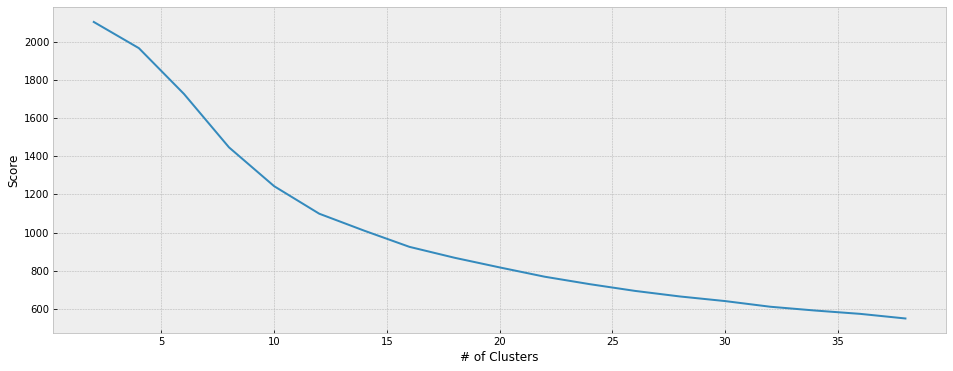


The Silhouette Coefficient Score (find max score):
Max Value:
Cluster #    Cluster Score
3       0.039347

Min Value:
Cluster #    Cluster Score
7       0.028109


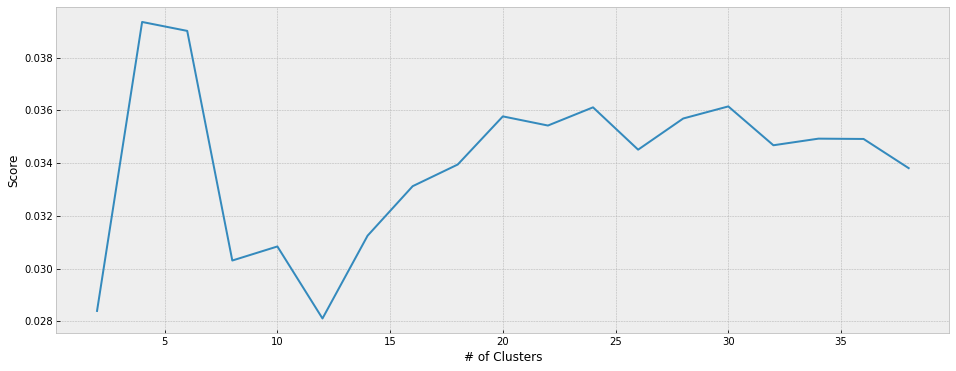


The Davies-Bouldin Score (find minimum score):
Max Value:
Cluster #    Cluster Score
2       5.790109

Min Value:
Cluster #     Cluster Score
20       3.604755


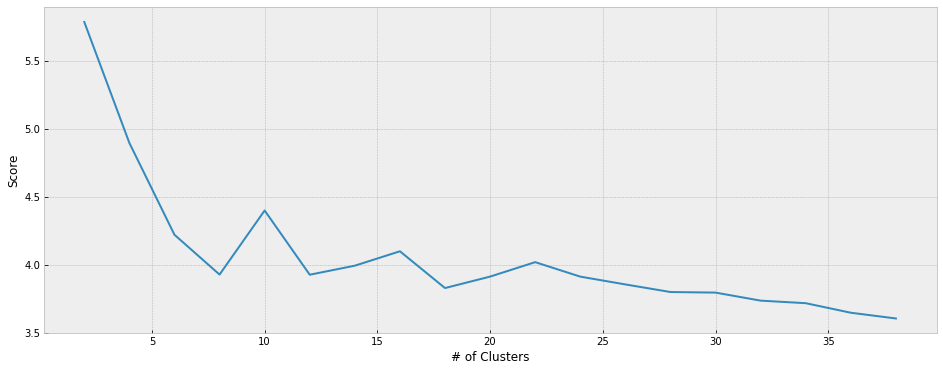

In [13]:
print("The Calinski-Harabasz Score (find max score):")
cluster_eval(ch_scores, cluster_cnt)

print("\nThe Silhouette Coefficient Score (find max score):")
cluster_eval(s_scores, cluster_cnt)

print("\nThe Davies-Bouldin Score (find minimum score):")
cluster_eval(db_scores, cluster_cnt)

### Running KMeans using optimized stuff


In [14]:
# Instantiating HAC based on the optimum number of clusters found
kmeans = KMeans(n_clusters=3)

# Fitting
kmeans.fit(df_pca)

# Getting cluster assignments
cluster_assignments = pd.Series(kmeans.labels_)
# print(df.shape[0])
# Assigning the clusters to each profile
df['Cluster #'] = cluster_assignments

vect_df['Cluster #'] = cluster_assignments

In [15]:
with open("refined_cluster.pkl",'wb') as fp:
    pickle.dump(df, fp)
    
with open("vectorized_refined.pkl", 'wb') as fp:
    pickle.dump(vect_df, fp)

Matching new profile to previous ones

In [16]:
# Importing 3 models
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import ComplementNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier

In [17]:
# Perform training, splitting and testing
#  Assigning the split variables
X = vect_df.drop(["Cluster #"], 1)
y = vect_df['Cluster #']

# Train, test, split
X_train, X_test, y_train, y_test = train_test_split(X, y)

/var/folders/jt/9fgtl63s7gv_96_wct99jv2c0000gn/T/ipykernel_67438/2272284977.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = vect_df.drop(["Cluster #"], 1)


### Finding the Best Model
- Dummy (Baseline Model)
- KNN
- SVM
- NaiveBayes
- Logistic Regression
- Adaboost

In [18]:
# Dummy
dummy = DummyClassifier(strategy='stratified')

# KNN
knn = KNeighborsClassifier()

# SVM
svm = SVC(gamma='scale')

# NaiveBayes
nb = ComplementNB()

# Logistic Regression
lr = LogisticRegression()

# Adaboost
adab = AdaBoostClassifier()

# List of models
models = [dummy, knn, svm, nb, lr, adab]

# List of model names
names = ['Dummy', 'KNN', 'SVM', 'NaiveBayes', 'Logistic Regression', 'Adaboost']

# Zipping the lists
classifiers = dict(zip(names, models))

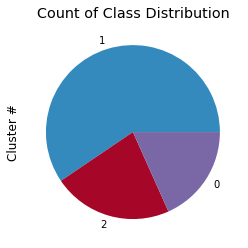

In [19]:
# Visualization of the different cluster counts
vect_df['Cluster #'].value_counts().plot(kind='pie', title='Count of Class Distribution');

Since we are dealing with an imbalanced dataset _(because each cluster is not guaranteed to have the same amount of profiles)_, we will resort to using the __Macro Avg__ and __F1 Score__ for evaluating the performances of each model.

In [20]:
# Dictionary containing the model names and their scores
models_f1 = {}

# Looping through each model's predictions and getting their classification reports
for name, model in tqdm(classifiers.items()):
    # Fitting the model
    model.fit(X_train, y_train)
    
    print('\n'+ name + ' (Macro Avg - F1 Score):')
    
    # Classification Report
    report = classification_report(y_test, model.predict(X_test), output_dict=True)
    f1 = report['macro avg']['f1-score']
    
    # Assigning to the Dictionary
    models_f1[name] = f1
    
    print(f1)

  0%|          | 0/6 [00:00<?, ?it/s]


Dummy (Macro Avg - F1 Score):
0.33276579458733896

KNN (Macro Avg - F1 Score):
0.9641107806330557

SVM (Macro Avg - F1 Score):
1.0

NaiveBayes (Macro Avg - F1 Score):
0.9999343505635143

Logistic Regression (Macro Avg - F1 Score):
1.0

Adaboost (Macro Avg - F1 Score):
1.0


Finding model with the best performance

In [21]:
print(max(models_f1, key=models_f1.get), 'Score:', max(models_f1.values()))

SVM Score: 1.0


In [52]:
# Fitting the model
# nb.fit(X, y)
svm.fit(X_train,y_train)

SVC()

In [22]:
nb.fit(X_train, y_train)

ComplementNB()

In [53]:
knn.fit(X_train, y_train)

KNeighborsClassifier()

Saving the model

In [23]:
from joblib import dump

dump(nb, "refined_model.joblib")

['refined_model.joblib']